In [ ]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU available


In [ ]:
from moviepy.editor import VideoFileClip
clip=VideoFileClip("data/archive (1)/RAVDESS dataset/Video_Speech_Actor_01/Actor_01/01-01-05-01-01-01-01.mp4").resize(width=256,height=256)
clip.fps
#clip.ipython_display()

29.97002997002997

In [ ]:
sr=8000
ad=clip.subclip(t_start=1,t_end=1.2).audio.to_soundarray(fps=sr)
ad.shape

(1600, 2)

In [ ]:
ad.shape[0]/clip.duration

410.2564102564103

In [ ]:
import librosa
mel=librosa.feature.melspectrogram(y=ad, sr=sr )
mel.shape

In [ ]:
mel.min()

0.0

In [ ]:
mel.dtype

dtype('float64')

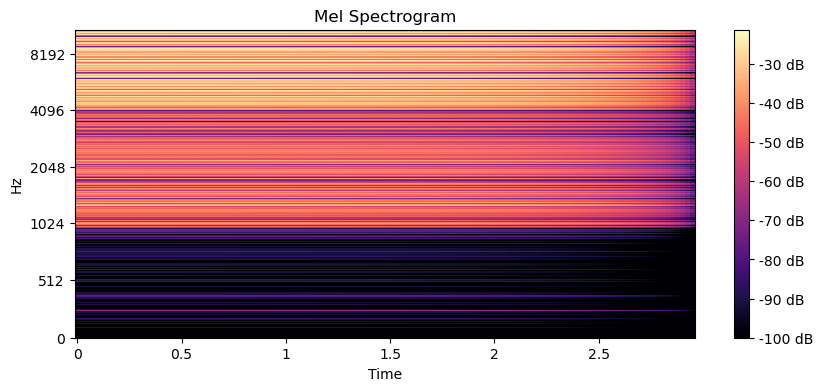

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
log_mel_spectrogram = librosa.power_to_db(mel.squeeze(axis=2)).astype(np.float32)
librosa.display.specshow(log_mel_spectrogram, y_axis='mel', x_axis='time')
plt.colorbar(format="%+2.f dB")
plt.title("Mel Spectrogram")
plt.show()

In [1]:
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

# use get_data_loaders to get the data_loaders dictionary. Use a batch_size
# of 5, a validation size of 0.01 and num_workers=-1 (all CPUs)
data_loaders = get_data_loaders(batch_size=6, num_workers=2, is_mel=False)
print(len(data_loaders['valid']))

Dataset mean: tensor([0.4850, 0.4560, 0.4060]), std: tensor([0.2290, 0.2240, 0.2250])
875


In [4]:
images, labels=next(iter(data_loaders['valid']))
len(labels.unique())

5

In [5]:
images[0].shape

torch.Size([3, 230, 230])

In [18]:
valid_im_size=220

In [19]:
im_deff= (images[0].shape[-1]-valid_im_size)//2
last_cut=images[0].shape[-1]-im_deff
x = images[0][:,im_deff:last_cut,im_deff:last_cut]
x.shape

torch.Size([3, 220, 220])

In [20]:
im_deff,last_cut

(5, 225)

In [ ]:
from src.train import to_device
images, labels=to_device(images, labels)
images[0].shape

torch.Size([6, 3, 200, 200])

In [ ]:
len(labels)

128

In [5]:
import torch
from src.models.image import MyModel2
torch_model=MyModel2(num_classes=8)
torch_input = torch.randn(1, 3, 256, 256)
onnx_program = torch.onnx.dynamo_export(torch_model, torch_input)
onnx_program

/home/naif/miniconda3/envs/MLenv/lib/python3.11/site-packages/torch/onnx/_internal/exporter.py:136: UserWarning: torch.onnx.dynamo_export only implements opset version 18 for now. If you need to use a different opset version, please register them with register_custom_op.
  warnings.warn(


OnnxExporterError: Failed to export the model to ONNX. Generating SARIF report at 'report_dynamo_export.sarif'. SARIF is a standard format for the output of static analysis tools. SARIF logs can be loaded in VS Code SARIF viewer extension, or SARIF web viewer (https://microsoft.github.io/sarif-web-component/). Please report a bug on PyTorch Github: https://github.com/pytorch/pytorch/issues

--------------------------

In [1]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std
from src.models.image import get_model_transfer_learning
from src.data import get_data_loaders
from src.data import valid_im_size
import torch

data_loaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes


# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model = get_model_transfer_learning('shufflenet_v2_x1_0',n_classes=8).cpu()

# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)

model.load_state_dict(torch.load('checkpoints/best_shufflenet_v2_x1_0.pt')['model_state_dict'])

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names,valid_im_size, mean, std).cpu()


# dummy_input = torch.zeros(1,3,256,256)
# # inputs = ['images']
# # outputs = ['scores']
# # dynamic_axes= {'input':{0:'batch_size' , 2:'width', 3:'height'}, 'output':{0:'batch_size' , 2:'width', 3:'height'}}
# torch.onnx.export(predictor, dummy_input, 'model.onnx', verbose=True)


# Export using torch.jit.script
scripted_predictor =torch.jit.script(predictor) 

scripted_predictor.save("checkpoints/original_exported.pt")

Dataset mean: tensor([0.4850, 0.4560, 0.4060]), std: tensor([0.2290, 0.2240, 0.2250])


In [2]:
predictor.class_names[0]

'Angry'

In [7]:
predictor.class_names.codes

10076    2
4059     7
8373     5
14675    3
21429    4
        ..
6495     1
3887     0
2677     1
8434     1
5716     2
Length: 20993, dtype: int8